In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from os import path

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Paths
BASE_DATASET_PATH = "./"
TRAIN_DATASET_PATH = path.join(BASE_DATASET_PATH,"train_processed.csv")
TEST_DATASET_PATH = path.join(BASE_DATASET_PATH,"test_processed.csv")
TEST_LABELS_PATH = path.join(BASE_DATASET_PATH,"test_labels.csv")

# Common Columns
DATA_COLUMNS = ["comment_text"]
LABEL_COLUMNS = ["toxic",'severe_toxic','obscene','threat','insult','identity_hate']

# Training Parameters
SHUFFLE_BUFFER_SIZE=160000
BATCH_SIZE = 16
PREFETCH=8

Num GPUs Available:  1


In [ ]:
train_dataset = pd.read_csv('./train_processed.csv')
train_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [ ]:
def fix_dataset_type(dataset):
    cols = dataset.select_dtypes(include=['object'])
    for col in cols.columns.values:
        dataset[col] = dataset[col].fillna('')
    return dataset
train_dataset = fix_dataset_type(train_dataset)

In [ ]:
x_train = np.array(train_dataset[DATA_COLUMNS])
y_train = np.array(train_dataset[LABEL_COLUMNS])
x_train = x_train.flatten()
x_train

array(['explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since im retired now892053827',
       'daww match background colour im seemingly stuck thanks talk 2151 january 11 2016 utc',
       'hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
       ...,
       'spitzer umm there actual article prostitution ring crunch captain',
       'look like actually put speedy first version deleted look',
       'really dont think understand came idea bad right away kind community go bad idea go away instead helping rewrite'],
      dtype=object)

In [ ]:
from keras.layers import TextVectorization

vectorizer = TextVectorization(output_sequence_length=1800,output_mode='int')
vectorizer.adapt(x_train)


In [ ]:
# Note - On windows this might not work due to encoding problem.
# In order to fix that, you need to go to language settings -> Administrative language settings -> Change system locale -> and set checkbox of "Use Unicode UTF-8..."
MAX_FEATURES = len(vectorizer.get_vocabulary())
MAX_FEATURES

245355

In [ ]:
x_train = vectorizer(x_train)
x_train

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[   464,     55,     58, ...,      0,      0,      0],
       [207879,    966,   1210, ...,      0,      0,      0],
       [   322,    321,     16, ...,      0,      0,      0],
       ...,
       [ 29048,   6754,    278, ...,      0,      0,      0],
       [    50,      9,    125, ...,      0,      0,      0],
       [    61,     10,     13, ...,      0,      0,      0]])>

In [ ]:
from tensorflow import data
train_dataset = data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(PREFETCH)
len(train_dataset)

9974

In [ ]:
train_dataset = train_dataset.take(int(len(train_dataset)*0.8))
validation_dataset = train_dataset.skip(int(len(train_dataset)*0.8)).take(int(len(train_dataset)*0.2))
print(len(train_dataset))
print(len(validation_dataset))

7979
1595


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,Embedding

model = Sequential()

model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(6,activation='sigmoid'))
model.compile(loss="BinaryCrossentropy",optimizer="adam",metrics=['binary_accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          7851392   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
%%time
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,epochs=5,batch_size=BATCH_SIZE,validation_data=validation_dataset)

Epoch 1/5
7979/7979 [==============================] - 788s 97ms/step - loss: 0.0600 - binary_accuracy: 0.9796 - val_loss: 0.0433 - val_binary_accuracy: 0.9832
Epoch 2/5
7979/7979 [==============================] - 757s 95ms/step - loss: 0.0434 - binary_accuracy: 0.9834 - val_loss: 0.0367 - val_binary_accuracy: 0.9856
Epoch 3/5
7979/7979 [==============================] - 735s 92ms/step - loss: 0.0372 - binary_accuracy: 0.9854 - val_loss: 0.0316 - val_binary_accuracy: 0.9873
Epoch 4/5
7979/7979 [==============================] - 737s 92ms/step - loss: 0.0323 - binary_accuracy: 0.9871 - val_loss: 0.0278 - val_binary_accuracy: 0.9896
Epoch 5/5
7979/7979 [==============================] - 751s 94ms/step - loss: 0.0280 - binary_accuracy: 0.9890 - val_loss: 0.0240 - val_binary_accuracy: 0.9909
CPU times: user 1h 2min 40s, sys: 1min 5s, total: 1h 3min 45s
Wall time: 1h 4min 10s


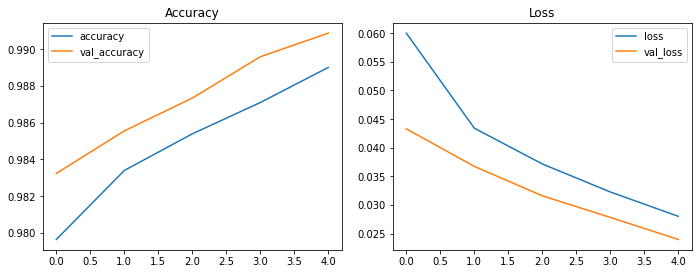

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(10, 4))

fig.tight_layout(pad=2.0)

ax[0].set_title("Accuracy")
ax[0].plot(history.history['binary_accuracy'],label='accuracy')
ax[0].plot(history.history['val_binary_accuracy'],label='val_accuracy')
ax[0].legend()

ax[1].set_title("Loss")
ax[1].plot(history.history['loss'],label='loss')
ax[1].plot(history.history['val_loss'],label='val_loss')
ax[1].legend()

In [ ]:
from pathlib import Path


model.save("./text_moderation_model_gc.h5",save_format="h5")
model_structure = model.to_json()
f = Path("./text_moderation_structure_gc.json")
f.write_text(model_structure)

3381

In [ ]:
val_x_set = x_train[int(len(x_train)*0.8):]
with tf.device('/device:GPU:0'):
  predictions = model.predict(val_x_set)

In [ ]:
predictions = (predictions>0.5).astype(int).flatten()
val_y_set = y_train[int(len(y_train)*0.8):].flatten()
correct = [(y==y_hat) for (y,y_hat) in zip(predictions,val_y_set)].count(1)
accuracy = (correct/len(predictions))*100
accuracy

99.09603634654552

In [ ]:
test_x_set = fix_dataset_type(pd.read_csv(TEST_DATASET_PATH))
test_y_set = pd.read_csv(TEST_LABELS_PATH)
good_rows = test_y_set[~test_y_set.isin([-1]).any(axis=1)]['id']

test_x_set = test_x_set.set_index("id").loc[good_rows]
test_y_set = test_y_set.set_index("id").loc[good_rows]

test_x_set = np.array(test_x_set[DATA_COLUMNS]).flatten()
test_y_set = np.array(test_y_set[LABEL_COLUMNS]).flatten()

In [ ]:
test_x_set = vectorizer(test_x_set)
test_x_set

<tf.Tensor: shape=(63978, 1800), dtype=int64, numpy=
array([[   56,   882,    13, ...,     0,     0,     0],
       [  859,   383,   140, ...,     0,     0,     0],
       [ 1021, 13395,   172, ...,     0,     0,     0],
       ...,
       [ 1977,    31,   723, ...,     0,     0,     0],
       [ 5735,  5886,   806, ...,     0,     0,     0],
       [14375, 23523,  3016, ...,     0,     0,     0]])>

In [ ]:
with tf.device('/device:GPU:0'):
  predictions = model.predict(test_x_set,batch_size=BATCH_SIZE)

In [ ]:
predictions = (predictions>0.5).astype(int).flatten()
correct = [(y==y_hat) for (y,y_hat) in zip(predictions,test_y_set)].count(1)
accuracy = (correct/len(predictions))*100
accuracy

95.5448226994696